In [3]:
DATA_PATH = '../data'
SHEET_NAME = None
TARGET = None
ID_COLS = []
FORCE_CATEGORICAL = []
FORCE_NUMERIC = []
SAMPLE_N = 1000
RANDOM_SEED = 42

In [7]:
os.listdir(DATA_PATH)[0]

'mexico_milk_prices.csv'

Dados carregados com sucesso
Dimensão: (52056, 6)


,Fecha,Estado,Ciudad,Tipo,Canal,Precio
0,2025-08-15,Aguascalientes,Aguascalientes,Pasteurizada,Tiendas,27.4
1,2025-08-15,Baja California,Mexicali,Pasteurizada,Tiendas,29.3
2,2025-08-15,Baja California,Tijuana,Pasteurizada,Tiendas,NaN
3,2025-08-15,Baja California Sur,La Paz,Pasteurizada,Tiendas,26.0
4,2025-08-15,Campeche,Campeche,Pasteurizada,Tiendas,NaN



Tipos e não-nulos por coluna:


,dtype
Fecha,object
Estado,object
Ciudad,object
Tipo,object
Canal,object
Precio,float64



Contagem de valores nulos (colunas com >0 nulos):


Precio    6511
dtype: int64

Colunas numéricas: ['Precio']
Colunas categóricas: ['Fecha', 'Estado', 'Ciudad', 'Tipo', 'Canal']


,count,mean,std,min,25%,50%,75%,max
Precio,45545.0,27.5424,5.18567,0.0,26.0,28.0,29.9,40.0



Coluna categórica: Fecha


Fecha
2025-08-15    216
2024-10-21    216
2024-08-05    216
2024-08-02    216
2024-07-31    216
2024-07-29    216
2024-07-26    216
2024-07-24    216
2024-07-22    216
2024-07-19    216
Name: count, dtype: int64


Coluna categórica: Estado


Estado
Tamaulipas         4820
Sonora             3856
Veracruz           2892
Coahuila           2892
Guanajuato         1928
Quintana Roo       1928
Nuevo León         1928
Baja California    1928
Jalisco            1928
Guerrero           1928
Name: count, dtype: int64


Coluna categórica: Ciudad


Ciudad
Aguascalientes     964
Nogales            964
ZM Monterrey       964
Oaxaca             964
Puebla             964
ZM Puebla          964
Querétaro          964
Cancún             964
Chetumal           964
San Luis Potosí    964
Name: count, dtype: int64


Coluna categórica: Tipo


Tipo
Pasteurizada         26028
Ultrapasteurizada    26028
Name: count, dtype: int64


Coluna categórica: Canal


Canal
Tiendas          26028
Autoservicios    26028
Name: count, dtype: int64

Precio    6511
dtype: int64

,missing_count,missing_pct
Precio,6511,12.51



== Precio


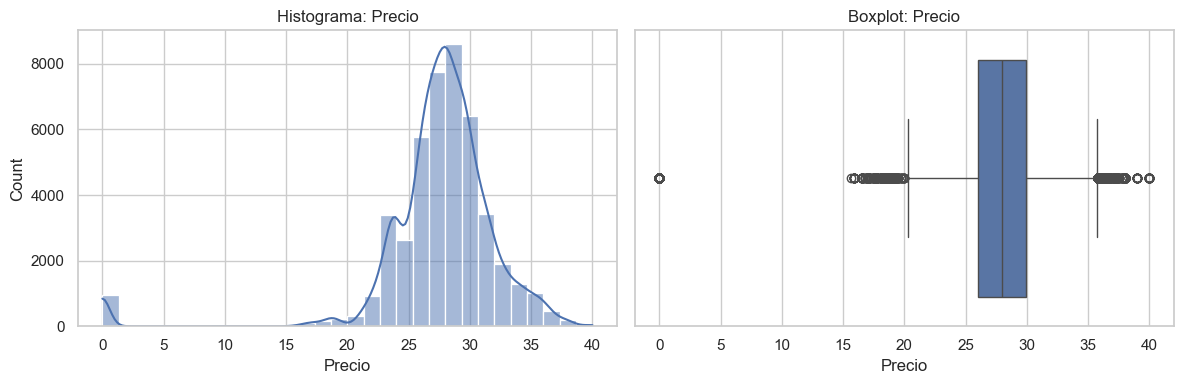


== Fecha


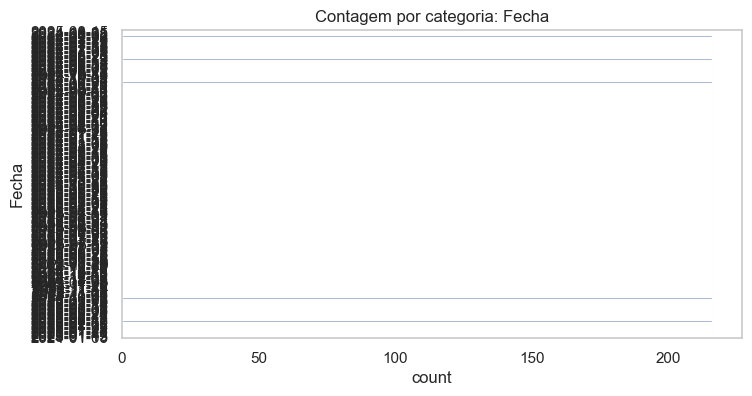


== Estado


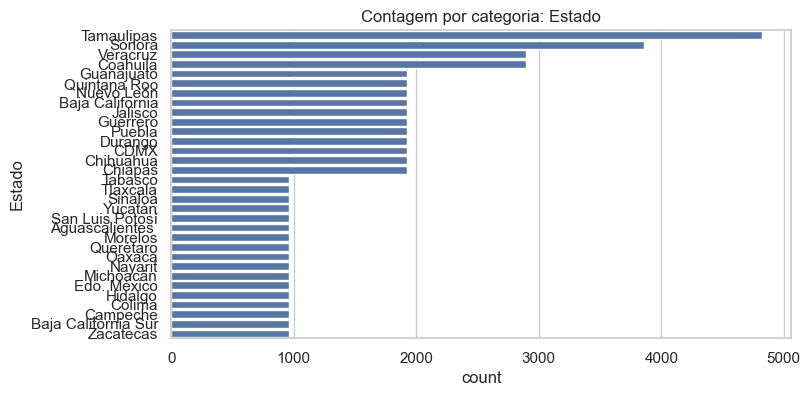


== Ciudad


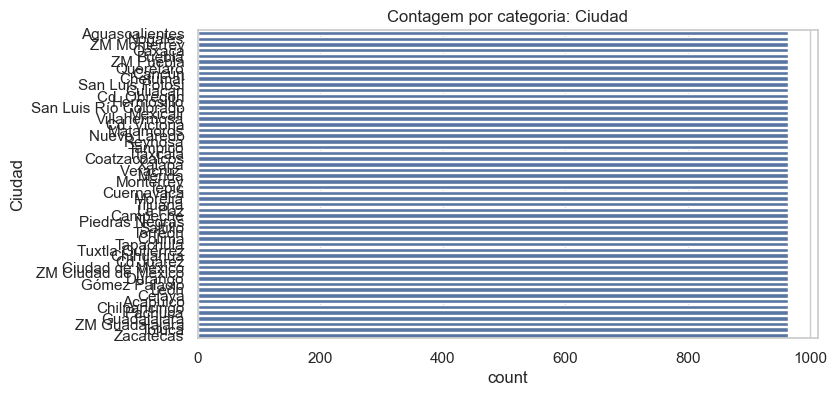


== Tipo


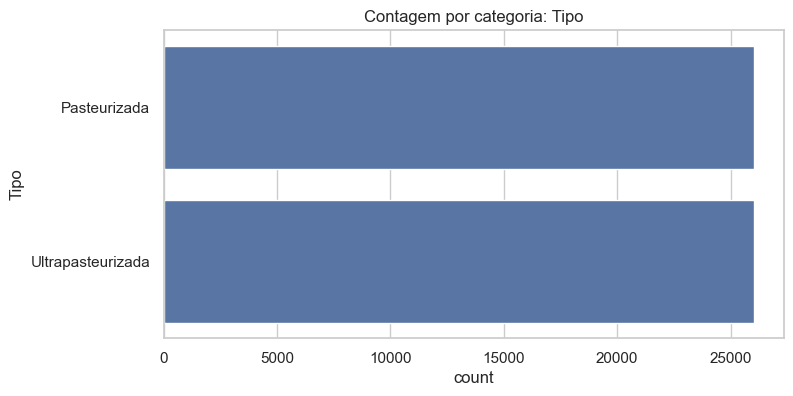


== Canal


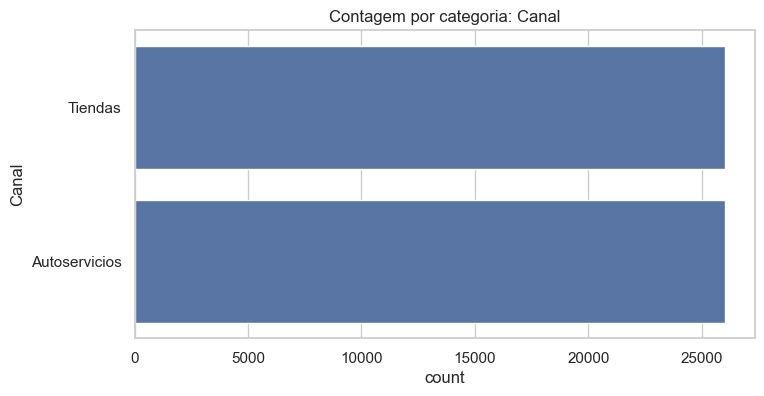

Poucas colunas numéricas para correlação
TARGET não informada; defina TARGET na configuração para esta seção
Dataset após imputação/encodificação rápida: (52056, 6)
Outliers detectados em Precio: 2373 valores
Puleu split: TARGET não informada ou não encontrada no dataset processado


In [9]:

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')
np.random.seed(RANDOM_SEED)

pd.options.display.max_columns = 200
pd.options.display.width = 120

def read_data(path):
    path = path + '/' + os.listdir(path)[0]
    # fallback
    return pd.read_csv(path)

def set_dtypes(df):
    for c in FORCE_CATEGORICAL:
        if c in df.columns:
            df[c] = df[c].astype('category')
    for c in FORCE_NUMERIC:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

def basic_report(df):
    print('Dimensão:', df.shape)
    display(df.head())
    print('\nTipos e não-nulos por coluna:')
    display(pd.DataFrame(df.dtypes, columns=['dtype']))
    print('\nContagem de valores nulos (colunas com >0 nulos):')
    display(df.isna().sum().loc[lambda x: x>0].sort_values(ascending=False))

def summary_statistics(df, numeric_only=True):
    if numeric_only:
        return df.describe().T
    else:
        return df.describe(include='all').T

def top_categories(df, col, n=10):
    return df[col].value_counts(dropna=False).head(n)

def sample_if_large(df, n=SAMPLE_N):
    return df.sample(n) if len(df)>n else df.copy()

def plot_hist_box(df, col, bins=30):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[col].dropna(), bins=bins, ax=axes[0], kde=True)
    axes[0].set_title(f'Histograma: {col}')
    sns.boxplot(x=df[col].dropna(), ax=axes[1])
    axes[1].set_title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

def plot_count(df, col):
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Contagem por categoria: {col}')
    plt.show()

def corr_matrix(df, numeric_only=True):
    if numeric_only:
        num = df.select_dtypes(include=[np.number])
    else:
        num = df.copy()
    corr = num.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink':.8})
    plt.title('Matriz de correlação')
    plt.show()

def analyze_target(df, target):
    if target not in df.columns:
        print('Target não encontrada')
        return
    if pd.api.types.is_numeric_dtype(df[target]):
        print('Estatísticas da target numérica:')
        display(df[target].describe())
        plt.figure(figsize=(6,4))
        sns.histplot(df[target].dropna(), kde=True)
        plt.title('Distribuição da target')
        plt.show()
    else:
        print('Contagem por classe da target categórica:')
        display(df[target].value_counts())
        plt.figure(figsize=(6,4))
        sns.countplot(x=target, data=df)
        plt.title('Contagem da target')
        plt.show()

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

# %%
# Carregar dados
df = read_data(DATA_PATH)
df = set_dtypes(df)
print('Dados carregados com sucesso')

# %%
# Relatório básico
basic_report(df)

# %%
# Separar colunas numéricas e categóricas automaticamente
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['category','object','bool']).columns.tolist()
# remover id cols e target das listas se presentes
num_cols = [c for c in num_cols if c not in ID_COLS]
cat_cols = [c for c in cat_cols if c not in ID_COLS]
if TARGET:
    num_cols = [c for c in num_cols if c != TARGET]
    cat_cols = [c for c in cat_cols if c != TARGET]

print('Colunas numéricas:', num_cols)
print('Colunas categóricas:', cat_cols)

# %%
# Estatísticas descritivas numéricas
display(summary_statistics(df[num_cols]))

# Estatísticas para categóricas (top categories)
for c in cat_cols:
    print('\nColuna categórica:', c)
    display(top_categories(df, c, n=10))

# %%
# Valores faltantes
miss = df.isna().sum().sort_values(ascending=False)
miss = miss[miss>0]
display(miss)
if len(miss)>0:
    pct = (miss / len(df) * 100).round(2)
    display(pd.concat([miss, pct], axis=1, keys=['missing_count','missing_pct']))

# %%
# Visualizações univariadas automáticas (numéricas): histogramas e boxplots
for c in num_cols:
    try:
        print('\n==', c)
        plot_hist_box(df, c)
    except Exception as e:
        print('Erro ao plotar', c, e)

# %%
# Visualizações categóricas (top categories)
for c in cat_cols:
    try:
        print('\n==', c)
        plot_count(df, c)
    except Exception as e:
        print('Erro ao plotar', c, e)

# %%
# Matriz de correlação (entre numéricas)
if len(num_cols) > 1:
    corr_matrix(df[num_cols])
else:
    print('Poucas colunas numéricas para correlação')

# %%
# Análise da target (se informada)
if TARGET:
    analyze_target(df, TARGET)
else:
    print('TARGET não informada; defina TARGET na configuração para esta seção')

# %%
# Tratamento rápido de missing (exemplo) e codificação simples
def quick_impute_and_encode(df, numeric_strategy='median', fill_categorical='missing'):
    df_proc = df.copy()
    num = df_proc.select_dtypes(include=[np.number]).columns.tolist()
    cat = df_proc.select_dtypes(include=['object','category','bool']).columns.tolist()
    # Impute numéricos
    if num:
        imp_num = SimpleImputer(strategy=numeric_strategy)
        df_proc[num] = imp_num.fit_transform(df_proc[num])
    # Impute categóricos
    for c in cat:
        df_proc[c] = df_proc[c].fillna(fill_categorical)
        if df_proc[c].nunique() < 50:
            df_proc[c] = df_proc[c].astype('category')
    # One-hot para categóricas com poucas categorias
    small_cat = [c for c in cat if df_proc[c].nunique()<=10]
    if small_cat:
        df_proc = pd.get_dummies(df_proc, columns=small_cat, drop_first=True)
    return df_proc

df_proc = quick_impute_and_encode(df)
print('Dataset após imputação/encodificação rápida:', df_proc.shape)

# %%
# Detecção de outliers (IQR) em todas as numéricas
outliers = {c: detect_outliers_iqr(df[c].dropna()) for c in num_cols}
for c, series in outliers.items():
    if len(series)>0:
        print(f'Outliers detectados em {c}: {len(series)} valores')

# %%
# Split rápido em treino/teste (se target informada)
if TARGET and TARGET in df_proc.columns:
    X = df_proc.drop(columns=[TARGET]+ID_COLS if ID_COLS else [TARGET])
    y = df_proc[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    print('Tamanho treino/teste:', X_train.shape, X_test.shape)
else:
    print('Puleu split: TARGET não informada ou não encontrada no dataset processado')
